# Experimental Quantum Generative Adversarial Networks for Image Generation

Huang et al. describe two techniques to implement quantum generative adversarial networks on contemporary, NISQ quantum computers.  One technique (patch) optimizes for the case where the number of feature dimensions exceeds the number of dimensions in the quantum computer's state space, and another (batch) increases the amount of parallelism during training and generation.

In [ ]:
import pennylane as qml
import numpy as np
import torch as tr
from torch import tensor, nn, utils, optim
from torchvision import datasets, transforms
from math import pi
import matplotlib.pyplot as plt
from rich.progress import track

torch_dev = "cpu"

## Dataset

We use the MNIST handwritten digit database to replicate the results in the paper.

In [ ]:
# Filter the dataset to include on example with this label
class_filter = 0
# Resize the 28x28 MNIST digits down to this siz# Filter the dataset to include on example with this label
class_filter = 0
# Resize the 28x28 MNIST digits down to this size
image_size = 8

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])
dataset = datasets.MNIST(
    'data', train=True, download=True, transform=data_transform
)
dataset_filtered = utils.data.Subset(
    dataset, np.nonzero(dataset.targets == class_filter).view(-1)
)
data_loader = utils.data.DataLoader(dataset_filtered, batch_size=1, num_workers=16)

## Patch GAN

The patch GAN setup employs a quantum generator and a classical discriminator.

[An article](https://pennylane.ai/qml/demos/tutorial_quantum_gans.html) by James Ellis for PennyLane contains an implementation of this strategy, and this code is the almost verbatim from that article.

In [ ]:
qubits = 5
qubits_ancillary = 1
gen_depth = 6

patch_size = (2, 8)
assert 2**(qubits - qubits_ancillary) == patch_size[0]*patch_size[1]
assert image_size % patch_size[0] == 0 and image_size % patch_size[1] == 0
patch_num = (image_size // patch_size[0], image_size // patch_size[1])

train_iters = 500

gen_lr = 0.3
dis_lr = 0.01

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_size*image_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.stack(x)

In [ ]:
quantum_dev = qml.device('lightning.qubit', wires=qubits)

In [ ]:
@qml.qnode(quantum_dev, interface='torch', diff_method='parameter-shift')
def gen_circuit(noise, weights):
    for i in range(qubits):
        qml.RY(noise[i], wires=i)
    for i in range(gen_depth):
        for y in range(qubits):
            qml.RY(weights[i,y], wires=y)
        for y in range(qubits-1):
            qml.CZ(wires=[y, y+1])
    return qml.probs(wires=list(range(qubits)))

In [ ]:
def partial_measure(noise, weights):
    probs = gen_circuit(noise, weights)
    probs_given_0 = probs[:2**(qubits-qubits_ancillary)]
    probs_given_0 /= tr.sum(probs)
    probs_given_0 = probs_given_0 / tr.max(probs_given_0)
    return probs_given_0.float()

In [ ]:
class PatchGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.ParameterList([
            nn.ParameterList([
                nn.Parameter(tr.rand(gen_depth, qubits), requires_grad=True)
                for _ in range(patch_num[1])
            ])
            for _ in range(patch_num[0])
        ])
        
    def forward(self, x):
        out = tr.zeros((0, image_size), device=torch_dev)
        for wr in self.weights:
            row = tr.zeros((patch_size[0], 0), device=torch_dev)
            for w in wr:
                y = partial_measure(x, w).reshape(patch_size)
                row = tr.cat((row, y), dim=1)
            out = tr.cat((out, row), dim=0)
        return out.reshape(1, image_size, image_size)

In [ ]:
gen_model = PatchGenerator().to(torch_dev)
dis_model = Discriminator().to(torch_dev)

loss_fn = nn.BCELoss()
gen_optimizer = optim.SGD(gen_model.parameters(), lr=gen_lr)
dis_optimizer = optim.SGD(dis_model.parameters(), lr=dis_lr)

real_labels = tr.full((1,), 1.0, dtype=tr.float, device=torch_dev)
fake_labels = tr.full((1,), 0.0, dtype=tr.float, device=torch_dev)

In [48]:
it = iter(data_loader)
for i, _ in zip(range(1000),it):
    pass

In [49]:
for i, (real_data, _) in zip(track(range(100)), it):
    real_data =  real_data.reshape(1, image_size, image_size).to(torch_dev)

    noise = tr.rand(qubits, device=torch_dev) * pi/2
    fake_data = gen_model(noise)

    dis_model.zero_grad()
    out_real = dis_model(real_data).view(-1)
    out_fake = dis_model(fake_data.detach()).view(-1)
    dis_err_real = loss_fn(out_real, real_labels)
    dis_err_fake = loss_fn(out_fake, fake_labels)
    dis_err_real.backward()
    dis_err_fake.backward()
    dis_err = dis_err_real + dis_err_fake
    dis_optimizer.step()

    gen_model.zero_grad()
    out_fake = dis_model(fake_data).view(-1)
    gen_err = loss_fn(out_fake, real_labels)
    gen_err.backward()
    gen_optimizer.step()
    
    if i % 10 == 0:
        print(f'gen: {gen_err:5.4f} dis: {dis_err:5.4f}')

Output()

gen: 4.3892 dis: 0.0138

gen: 4.5320 dis: 0.0120

gen: 4.5050 dis: 0.0127

gen: 4.4792 dis: 0.0121

gen: 4.6092 dis: 0.0111

gen: 4.5758 dis: 0.0111

gen: 4.5736 dis: 0.0112

gen: 4.5752 dis: 0.0109

gen: 4.8076 dis: 0.0086

gen: 4.6153 dis: 0.0127

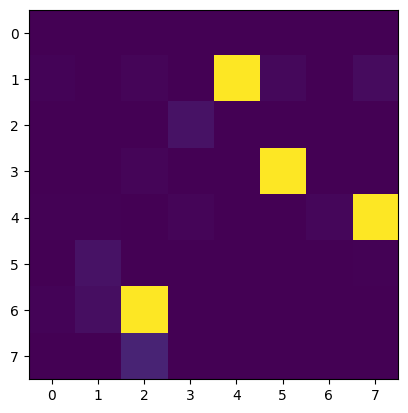

In [50]:
noise = tr.rand(qubits, device=torch_dev) * pi/2
plt.imshow(gen_model(noise)[0].cpu().detach())